**Introduction**

Quick foreword: This is my first notebook ever! I've been learning Python on-and-off for just over a year and Machine Learning on my own from books for about a year now. So any feedback is more than welcome, thanks!

The purpose of this Kernel is to investigate whether or not an accurate Machine Learning model can be built to forecast video game sales in units based on the features given in this dataset. This hypothesis is investigated with numerous supervised ML models.

Ultimately, a decision to forecast only aggregated global sales was made due to the inherently global nature of the video game industry. Several features were droppped in the process as well due to a huge potential influx of dummy variables post-feature engneering. 

Seven models were trained, out of which the lowest MSRE and best generalization is seen achieved by a Gradient Boosting Regressor model, which managed to outperform my first ever Deep Neural Network.

As a whole, this sort of prediction model could be used as one input out of many in business teams working for large video game developers.

A huge thanks to @Anisotropic, @Serigne and @juliencs! I learned a lot from your notebooks (see below) and I've directly copied some of your code. Please let me know if you have something against this!

https://www.kaggle.com/arthurtok/the-console-wars-ps-vs-xbox-vs-wii

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

**Getting Familiar With the Data**

> Let's import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
%matplotlib inline


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


C:\Users\ubaid\AppData\Local\Temp\ipykernel_21416\1444958516.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


> Let's get the data and preview the data

In [2]:
data = pd.read_csv('../data/Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In previewing the head of the data we have 16 columns in total. Now we have to decide 

a) Which sales feature do we want to use as the dependent variable

b) Which features do we want to use as the independent variables

Important things to consider here include making a distinction with platforms. There are platforms from both the current console generation and the previous one as well as many others.. As the video game industry has grown rapidly there may be significant time variance if we want to look at all consoles from each generation.

As the video game industry is global, let's have global sales as the dependent variable. This means later on we can drop all other sales features.

Before we decide on independent variables, let's do some more exploration first.



> Let's look at the size of the dataset

In [3]:
print(data.shape)

(16719, 16)


> Let's check for outliers between what I suspect to be, the most obvious pair of dependent and independent variables.

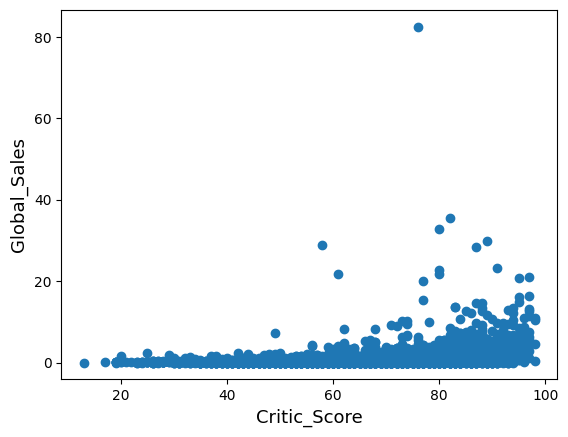

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = data['Critic_Score'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

> There's really only one clear outlier in the dataset, so lets get rid of it

In [5]:
data = data.drop(data[(data['Critic_Score']>60) & (data['Global_Sales']>60)].index)

> Let's check the plot again to confirm we are rid of the outlier

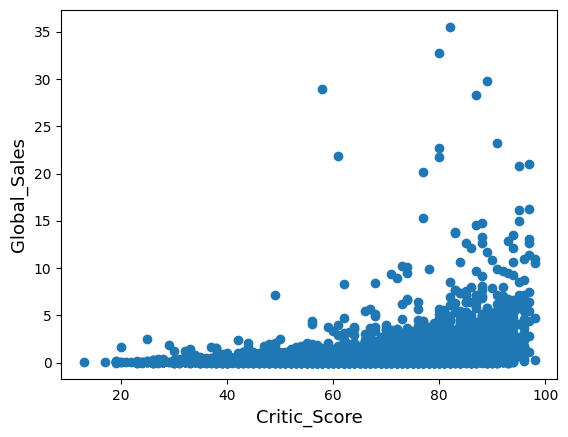

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = data['Critic_Score'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

Here we get to the question of "what constitutes an outlier?". If we look at the plot post-outlier removal, it still looks as if though there are outliers in the data. However, removing too many data points that are seemingly outliers may cross over to data tampering, which we don't want to get into. So for now, lets keep the data as it is.

**The Target Variable**

Our dependent variable is Global_Sales, so lets explore it some more.

> Let's look at its distribution


 mu = 0.53 and sigma = 1.41



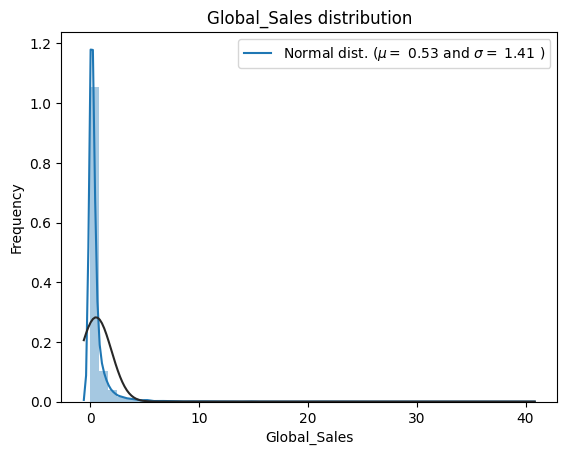

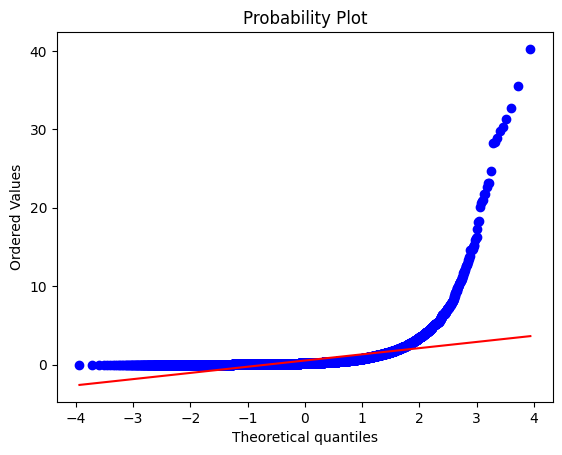

In [7]:
sns.distplot(data['Global_Sales'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['Global_Sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['Global_Sales'], plot=plt)
plt.show()

As we can see, Global_Sales is nowhere normally distributed, which may be problematic for us down the line. However, as we have yet to further investigate the data, let's not do any transformations just yet. We'll look at doing a log-transformation down the line.

Before we move on to splitting the data into training and test sets, lets look at some feature correlations, to ensure that our independent variables don't suffer from autocorrelation, which may be problematic in some linear models such as liner regression if we want to look at feature importance through the intercepts. Let's do this by plotting a correlation heatmap with Seaborn.

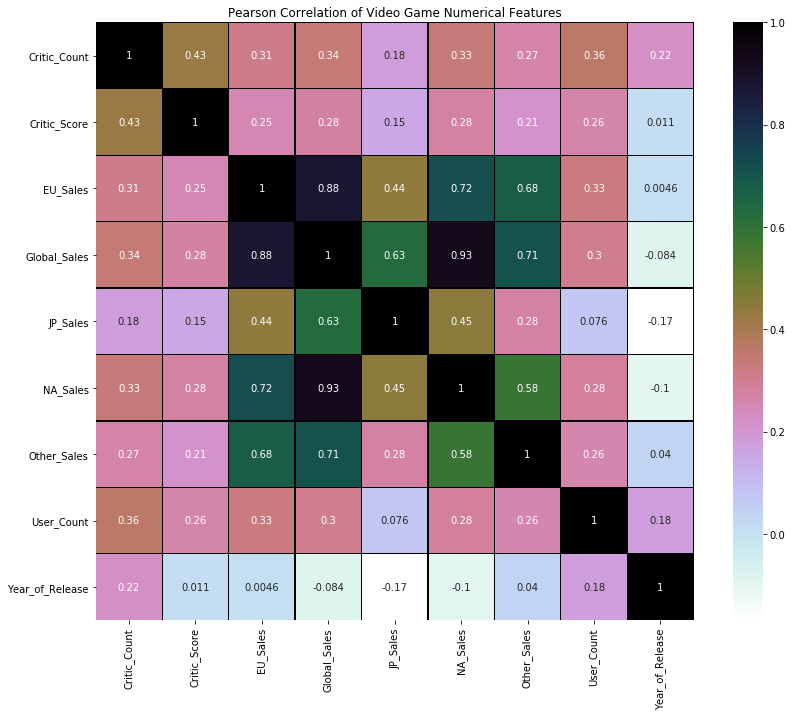

In [8]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data.iteritems():
    if type(colvalue[2]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
data_num = data[num_list]
f, ax = plt.subplots(figsize=(14, 11))
plt.title('Pearson Correlation of Video Game Numerical Features')
# Draw the heatmap using seaborn
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, 
            square=True, cmap="cubehelix_r", linecolor='k', annot=True)

In terms of autocorrelation the prospective independent variables aren't too highly correlated with each other in the correlation heat map. Only sales numbers are highly correlated with each other. Therefore we can look at intercepts of regression models without too much worries if we wish to do so later on. Higher correlations between sales figures may speak to the global nature of the video game industry: a success in one continent usually means a success in another continent as well. This lends greater confidence to using just Global_Sales as the dependent variable.

**Feature Engineering**

Let's look at what independent variables we will keep and whether there are N/A values etc.

> Let's look at what features have N/A values

In [9]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio
User_Count,54.605814
Critic_Count,51.333892
Critic_Score,51.333892
Rating,40.489293
User_Score,40.100490
Developer,39.615983
Year_of_Release,1.609044
Publisher,0.323005
Genre,0.011963
Name,0.011963


Here we have an issue. Critic_Score which may very well be the most important  independent variable, has almost 50 % of its values as N/A. Similarly roughly 40 % of data points are missing for User_Score which is highly likely one of the most important independent variables. This ratio of missing data is so large, that it cannot feasibly be filled with median values for instance.

Lets try a workaround. As previously mentioned, it may be more relevant to look at only current or previous generation consoles. So let's find out what all the consoles in the dataset are. Then lets choose a subset of those and this will likely automatically reduce the missing ratio of the independent variables as lesser known consoles and console games might not have Metacritic scores. Two birds with one stone.

In [10]:
print(pd.value_counts(data["Platform"]))

PS2     2161
DS      2152
PS3     1331
Wii     1319
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      432
PS4      393
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: Platform, dtype: int64


As we can see, there are actually a lot of different platforms in the dataset. As previously mentioned, it might be most relevant to look at only current gen consoles in our model, however the issue here is that we will have a limited amount of data. Therefore, let's widen our scope somewhat and look at the following platforms: PS3, PS4, X360, XOne, PC, Wii and WiiU. This ensures that we won't have too little data. Let's keep only relevant platforms.

In [11]:
data = data[(data['Platform'] == 'PS3') | (data['Platform'] == 'PS4') | (data['Platform'] == 'X360') | (data['Platform'] == 'XOne') | (data['Platform'] == 'Wii') | (data['Platform'] == 'WiiU') | (data['Platform'] == 'PC')]

#Let's double check the value counts to be sure
print(pd.value_counts(data["Platform"]))

#Let's see the shape of the data again
print(data.shape)

#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

PS3     1331
Wii     1319
X360    1262
PC       974
PS4      393
XOne     247
WiiU     147
Name: Platform, dtype: int64
(5673, 16)


,Missing Ratio
Critic_Count,37.493390
Critic_Score,37.493390
User_Count,34.584876
Rating,23.761678
User_Score,22.563018
Developer,21.716905
Year_of_Release,1.868500
Publisher,0.229156


So we still have almost 40 % of data points missing the critic score. This is still way too big, so let's drop all rows, that have N/A for Critic_Score. We cannot replace 40 % of the data with say, the median values. We must therefore eliminate N/A observations themselves.

In [12]:
data = data.dropna(subset=['Critic_Score'])

#Let's see the shape of the data again
print(data.shape)

#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

(3546, 16)


,Missing Ratio
User_Count,5.019741
Rating,2.002256
Year_of_Release,2.002256
User_Score,0.564016
Developer,0.084602
Publisher,0.084602


This looks better already. We've reached the point where we've dealt with N/A values for the most important variable and we still have enough data to work with. We still have to handle N/A values for the rest of the variables however, but this isn't as glaring of an issue as the missing ratios are relatively small, the highest being roughly 5 % for User_Count.

Let's deal with the rest of the N/A values next.

* For Publisher let's fill N/A's with the mode

In [13]:
data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])

* For Developer let's fill N/A's with the mode

In [14]:
data['Developer'] = data['Developer'].fillna(data['Developer'].mode()[0])

* For Rating let's fill N/A's with the mode

In [15]:
data['Rating'] = data['Rating'].fillna(data['Rating'].mode()[0])

* For Year_of_Release let's fill with the median value

In [16]:
data['Year_of_Release'] = data['Year_of_Release'].fillna(data['Year_of_Release'].median())

* For User_Score let's fill with the median value

In [17]:
#There's "tbd" values in the mix here which we need to handle first
data['User_Score'] = data['User_Score'].replace('tbd', None)

#Now we can handle the N/A's appropriately
data['User_Score'] = data['User_Score'].fillna(data['User_Score'].median())

* For User_Count let's fill with the median value

In [18]:
data['User_Count'] = data['User_Count'].fillna(data['User_Count'].median())

* Now let's verify that we don't have any more missing values

In [19]:
#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio


Hurray! We've dealt with all the missing values finally. Now let's deal with categorical values next. We need to change the following independent variables to dummy variables:

* Platform
* Genre
* Publisher
* Developer
* Rating

However, here we have an issue. Publisher and Developer will cause a massive influx of features as there are so many unique values in the mix. At this point it seems best to drop these features entirely.

Instead, let's only create dummies for:

* Platform
* Genre
* Rating

In [20]:
print(data.shape) #pre-dummies shape
data = pd.get_dummies(data=data, columns=['Platform', 'Genre', 'Rating'])
print(data.shape) #post-dummies shape
data.head #Check to verify that dummies are ok

(3546, 16)
(3546, 37)


<bound method NDFrame.head of                                             Name  Year_of_Release  \
2                                 Mario Kart Wii           2008.0   
3                              Wii Sports Resort           2009.0   
7                                       Wii Play           2006.0   
8                      New Super Mario Bros. Wii           2009.0   
13                                       Wii Fit           2007.0   
14                            Kinect Adventures!           2010.0   
15                                  Wii Fit Plus           2009.0   
16                            Grand Theft Auto V           2013.0   
23                            Grand Theft Auto V           2013.0   
29                Call of Duty: Modern Warfare 3           2011.0   
32                       Call of Duty: Black Ops           2010.0   
34                    Call of Duty: Black Ops II           2012.0   
35                    Call of Duty: Black Ops II           2012.0   
36  

Great! Let's drop the features we wish to discard for our models. These include:

* Name
* Publisher
* Developer
* NA_Sales
* EU_Sales
* JP_Sales
* Other_Sales

In [21]:
data = data.drop(['Name', 'Publisher', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)

 Let's define X and Y and then split into training and test data

In [22]:
print(data.columns) #easy to copy-paste the values to rearrange from here

X = data[['Year_of_Release', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Platform_PC', 'Platform_PS3',
       'Platform_PS4', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XOne', 'Genre_Action', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+', 'Rating_M',
       'Rating_RP', 'Rating_T']]

Y = data[['Global_Sales']]

#Double checking the shape
print(X.shape)
print(Y.shape)

Index(['Year_of_Release', 'Global_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Platform_PC', 'Platform_PS3',
       'Platform_PS4', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XOne', 'Genre_Action', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+', 'Rating_M',
       'Rating_RP', 'Rating_T'],
      dtype='object')
(3546, 29)
(3546, 1)


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

#Let's check the shape of the split data as a precaution
print("X_train shape: {}".format(X_train.shape))
print("Y_train shape: {}".format(Y_train.shape))

print("X_test shape: {}".format(X_test.shape))
print("Y_test shape: {}".format(Y_test.shape))

X_train shape: (2659, 29)
Y_train shape: (2659, 1)
X_test shape: (887, 29)
Y_test shape: (887, 1)


Now that we have the test split into training and test data we can still do some final scaling of the data before fitting the models. 

As mentioned previously, lets do a log-transformation of the dependent variable in both the training and test data.

In [24]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)


 mu = 0.43 and sigma = 0.48



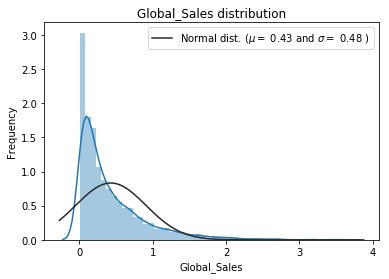

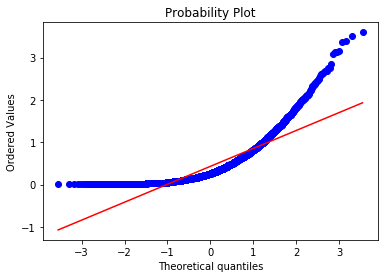

In [25]:
#Check the new distribution 
Y_log_transformed = np.log1p(data['Global_Sales']) #For comparison to earlier, here's the whole Y transformed
sns.distplot(Y_log_transformed , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_log_transformed)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_log_transformed, plot=plt)
plt.show()


As we can see, the log-transformation didn't do too much to help us normalize the data. To be honest, this step might not be all that useful, especially if we choose to fit models that can handle non-linear data pretty well. None the less, not much harm done either, so let's proceed.

Let's fit X_train and scale X_train and X_test with the MinMax Scaler to get all independent variables in a similar range.

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

Now we are really close to the fun part. First however, we need to prepare our grids for grid search. For this, we need to decide, which models we will use. So let's try:

* Linear Regression
* Lasso
* Ridge Regression
* Support Vector Regressor
* Random Forest
* Gradient Boosting Regressor
* MLP Regressor a.k.a. a Neural Network

In [27]:
#No grid to define for vanilla linear regression
param_grid_lr = [
    {}
]

#Parameter grid for lasso
param_grid_lasso = [
    {'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'max_iter': [1000000, 100000, 10000, 1000]}
]

#Parameter grid for Ridge Regression
param_grid_rr = [
    {'alpha': [100, 10, 1, 0.1, 0.01, 0.001]}
]

#Parameter grid for Support Vector Regressor
param_grid_svr = [
    {'C': [0.01, 0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
     'kernel': ['rbf']}
]

#Parameter grid for Random Forest
param_grid_rf = [
    {'n_estimators': [3, 10, 30, 50, 70], 'max_features': [2,4,6,8,10,12], 'max_depth': [2, 3, 5, 7, 9]}
]

#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 225, 250, 275], 'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}
]

#Parameter grid for MLPRegressor. 
#Current set of hyperparameters are the result of grid search that took forever.
param_grid_mlpr = [
    {'hidden_layer_sizes': [(10,5)], 'solver': ['lbfgs'], 'batch_size': [200],
     'learning_rate': ['adaptive'], 'max_iter': [800], 'verbose': [True], 
     'nesterovs_momentum': [True], 'early_stopping': [True], 'validation_fraction': [0.12],
     'random_state': [100], 'alpha': [0.1], 'activation': ['logistic']}
]

Now that we have the parameter grids, let's implement the models one by one and see which does the best. 

Let's use RMSE for scoring the models. The interpretation for RMSE, or Root Mean Squared Error, is more intuitive than that of the MSE as RMSE is an absolute measure of fit. It thus tells us our error in actual sales units. Also, to quote theanalysisfactor.com: "RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction."

However, before interpreting the RMSE, we must also do an exp transformation on the RMSE scores to undo the log transformation and for the results to be more easily interpreted. Otherwise the RMSE will be in log(Global_Sales).

In conjunction with our grid search, let's use cross-validation with 5 folds.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error',  cv=5)
grid_search_lr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lr.best_params_))
lr_best_cross_val_score = (np.sqrt(-grid_search_lr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lr_best_cross_val_score)))
lr_score = np.sqrt(-grid_search_lr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lr_score)))

Best parameters: {}
Best cross-validation score: 0.41
Test set score: 0.43


In [29]:
from sklearn.linear_model import Lasso

grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lasso.best_params_))
lasso_best_cross_val_score = (np.sqrt(-grid_search_lasso.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lasso_best_cross_val_score)))
lasso_score = np.sqrt(-grid_search_lasso.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lasso_score)))

Best parameters: {'alpha': 0.0001, 'max_iter': 1000000}
Best cross-validation score: 0.41
Test set score: 0.43


In [30]:
from sklearn.linear_model import Ridge

grid_search_rr = GridSearchCV(Ridge(), param_grid_rr, cv=5, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rr.best_params_))
rr_best_cross_val_score = (np.sqrt(-grid_search_rr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rr_best_cross_val_score)))
rr_score = np.sqrt(-grid_search_rr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rr_score)))

Best parameters: {'alpha': 10}
Best cross-validation score: 0.41
Test set score: 0.43


In [31]:
from sklearn.svm import SVR

grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_svr.best_params_))
svr_best_cross_val_score = (np.sqrt(-grid_search_svr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(svr_best_cross_val_score)))
svr_score = np.sqrt(-grid_search_svr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(svr_score)))

Best parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Best cross-validation score: 0.47
Test set score: 0.50


In [32]:
from sklearn.ensemble import RandomForestRegressor

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rf.best_params_))
rf_best_cross_val_score = (np.sqrt(-grid_search_rf.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rf_best_cross_val_score)))
rf_score = np.sqrt(-grid_search_rf.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rf_score)))

Best parameters: {'max_depth': 9, 'max_features': 12, 'n_estimators': 70}
Best cross-validation score: 0.34
Test set score: 0.36


In [33]:
from sklearn.ensemble import GradientBoostingRegressor

grid_search_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_gbr.best_params_))
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(gbr_best_cross_val_score)))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(gbr_score)))

Best parameters: {'max_depth': 5, 'max_features': 6, 'n_estimators': 275}
Best cross-validation score: 0.33
Test set score: 0.33


In [34]:
from sklearn.neural_network import MLPRegressor

grid_search_mlpr = GridSearchCV(MLPRegressor(), param_grid_mlpr, cv=5, scoring='neg_mean_squared_error')
grid_search_mlpr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_mlpr.best_params_))
mlpr_best_cross_val_score = (np.sqrt(-grid_search_mlpr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(mlpr_best_cross_val_score)))
mlpr_score = np.sqrt(-grid_search_mlpr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(mlpr_score)))

Best parameters: {'activation': 'logistic', 'alpha': 0.1, 'batch_size': 200, 'early_stopping': True, 'hidden_layer_sizes': (10, 5), 'learning_rate': 'adaptive', 'max_iter': 800, 'nesterovs_momentum': True, 'random_state': 100, 'solver': 'lbfgs', 'validation_fraction': 0.12, 'verbose': True}
Best cross-validation score: 0.41
Test set score: 0.40


So the best model out of the seven we trained is the GBR! Let's therefore take a loot at the feature importances of the model as well to find out which features are the most important ones in explaining the results.

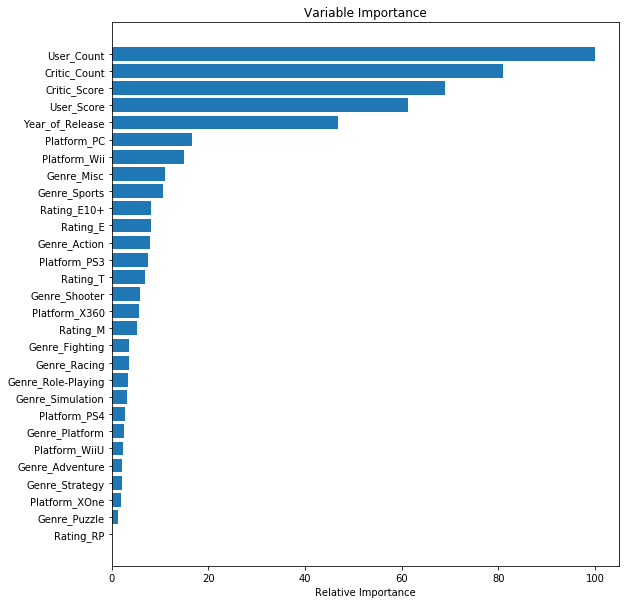

In [35]:
# Plot feature importance
feature_importance = grid_search_gbr.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[sorted_idx]) #Not 100 % sure the feature names match the importances correctly...
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**Results**

Surprisingly, the best model IS NOT the deep neural network. Instead it's the Gradient Boosting Regressor. I would have initially picked it out to be the second best one out of the lot. This speaks to it's power as a model and also to the fact that training deep neural networks is challenging and a lot of the time it seems that you're better off choosing a simpler model, as the computational expense that DNN's bring with them may not justify the decrease in MSRE. In a sense it's kind of a "don't bring a gun to a fistfight" type of situation, if that makes any sense... 

As this was my first time training a neural network, it really dawned on me how difficult tuning those hyperparameters is to optimize your model. At the same time I can more clearly see the value in using a library like Tensorflow for training DNN's as the library brings more flexibility that can prove to be invaluable. 

Anyway, on to the analysis of the results! So the GBR's best cross-validation score and its test score are both 0.33 as measured in RMSE. This means that first off, the model generalizes well as the difference between the cross-validation score and the test set score is negligible. In more concrete terms however, it means that the average error the model makes in its predicitons amount to 330k units. That means that in making a forecast, on average the model will be wrong in forecasting video game sales by 330k units.

Additionally, an interesting finding is that the amount of users and the amount of critics rating a game on Metacritic is more important in explaining the results than the scores themselves. My initial hypothesis would have been the other way around. In this regard, it seems that it doesn't necessarily matter as much that a game has a single esteemed critic scoring the game a 100, but rather that the game has lots of critics scoring it potentially even at a lower level to drive those unit sales.

Another interesting finding is that the year of release is the fifth most important factor in explaingin the results. I would wager here that this is an indication of the fast growing video game industry: as the value for the year increases, unit sales increases mainly due to the market itself growing.

In terms of platforms, the only ones that maintained some relevant measure of explanatory power was whether the game was released on PC and whether it was released on Wii. There may be many interpretations here, so it is best to be wary in interpreting this. A game being released on Wii might speak towards explaining lower unit sales due to the platform not being as popular as it's counter parts PS3 and Xbox 360. In the case of a game being released on PC, it is difficult to say which way this explanatory power goes, as PC is such a large platform with all kinds of games being released on it.

However, let's get to the real question: is the model good or not?

Well, it depends on the point of view. If you would use this model to forecast the unit sales of a small video game developer's game, you would be better of using other methods. The reason is that typically independent smaller studios sell under a million copies. In this case, an error of 330k units is a lot and can have a tremendous financial impact on the company, if you are relying on forecasting sales with this model. However, if you use this model to forecast the unit sales of larger AAA game developer's game, an error of 330k units, isn't that fatal. If you're forecasting the unit sales of a developer who typically sells say 3 million copies, then a roughly 10 % deviation is not fatal. Sure it isn't close to perfect, but these type of models typically aren't.

So where might this model come in valuable then? I think the most obvious example is in business teams in large video game companies. They typically make sales estimates that are then reflected in project budgets etc. and most of the time, the estimates are made in similar ways that for example equity analysts make forecasts: coming up with a number off of the top of your head :) This model could thus be used as an extra input in making those sales forecasts. 

To finish off: creating this kernel was a lot of fun! I appreciate all types of feedback as I'm only a beginner in both Python and Machine Learning! Thanks to anyone who took the time to read this and I hope you enjoyed it!


-jruots
